# Keypoint Detection

First, the reading and video lecture associated with this section:
Szeliski 4.1.  [Mubarak Shah's Lecture on Harris Corner detection](https://www.youtube.com/watch?v=S4mMhuLHrsQ&list=UUlOghZ_xkI1km31IeoY-9Bw).

Now that we have the capabililties in hand to run convolution operations on images, producing outputs that have strong responses to a variety of features (edges, for example), we are in a position to start looking for features in the image that might be good to match.  As it turns out, edges aren't good features to match at all, because they have a tendency to look similar all along the edge.  Instead, it's better to try and match corners.  This is the reasoning behind most keypoint detectors, and most panorama stitching applications work in this way.   

What defines a corner?  A corner is an object where there are big changes to the image no matter which direction we look.  We can reason about whether a given image patch exhibits this property by looking at a so-called *autocorrelation function*:
$$
E_{ac}(\Delta \mathbf{u}) = \sum_{i} w_i [I(\mathbf{u}_i + \Delta \mathbf{u}) - I(\mathbf{u}_i)]^2
$$
where $I$ is image intensity, $\Delta \mathbf{u}$ is a vector of position change, $w$ is an arbitrary kernel, and the summation is over a neighborhood of pixels.  This expression is a little unwieldly.  We can simplify it by approximating the perturbation term with a first order Taylor Series:
$$
E_{ac}(\Delta \mathbf{u}) = \sum_{i} w_i [I(\mathbf{u}_i) + \nabla I(\mathbf{u}_i) \Delta \mathbf{u} - I(\mathbf{u}_i)]^2.
$$
The two intensity terms cancel, and we're left with an expression that only depends on the gradient of the image (which we already know how to calculate).
$$
E_{ac}(\Delta \mathbf{u}) = \sum_{i} w_i [\nabla I(\mathbf{u}_i) \Delta \mathbf{u}]^2 = \Delta \mathbf{u}^T \mathbf{A} \Delta \mathbf{u},
$$
where we can define the (pixel-wise) auto-correlation matrix:
$$
A = \begin{bmatrix} \sum_i w_i \, \partial_u I_i^2 & \sum_i w_i \;\partial_u I_i \;\partial_v I_i \\
                    \sum_i w_i \; \partial_u I_i \; \partial_v I_i & \sum_i w_i \; \partial_v I_i^2 \end{bmatrix}
                                $$
or more concisely as 
$$
A = w \star \begin{bmatrix} \partial_u I^2 & \partial_u I \partial_v I \\
                            \partial_u I \partial_v I & \partial_v I^2 \end{bmatrix}
$$                            
This matrix has all the information about corners that we need in it.  Specifically, it's telling us the way that auto-correlation changes as we move in different directions.  

So given this information, what do we need to know to determine if a particular spot is a corner?  We can determine this by finding the eigenvalues of this matrix, which essentially tells us how much the autocorrelation is changing in the direction of the biggest change (the biggest eigenvalue, which we'll call $\lambda_0$), and also in the direction orthogonal to it (the second eigenvalue $\lambda_1$).  There are three cases that correspond to three possible situations.  First, it could be the case that both $\lambda_0$ and $\lambda_1$ are both very small.  This typically implies that there is not much contrast, and that there is not a corner, or even an edge.  The second case is when $\lambda_0>>\lambda_1$.  This implies that the image is changing alot in one direction, but not much at all in the other direction, which corresponds to an edge.  Finally we have the situation where $\lambda_0$ and $\lambda_1$ are both large and of similar magnitude.  This implies a corner.  The so-called Harris response 
$$h(\mathbf u) = \frac{\lambda_0 \lambda_1}{\lambda_0 + \lambda_1}$$ 
is designed to produce a large value whenever this latter condition is satisfied, and thus will be big for every point that is a corner.  

Note that it would be inefficient to actually form the matrix $A$ and solve for eigenvalues at every point on an image.  Instead we can recognize that both the numerator and the denominator in $h(\mathbf{u}$ are matrix invariants: $\lambda_0 \lambda_1 = \mathrm{Det}(\mathbf{A})$ and $\lambda_0 + \lambda_1 = \mathrm{Tr}(\mathbf{A})$.  Thus we get some pretty easy discrete formulas: 
$$
H = [I_{uu} \circ I_{vv} - I_{uv}\circ I_{uv}] \oslash [I_{uu} + I_{vv}],
$$
where $H$ is the pixel-wise Harris response and 
$$
I_{uu} = w \star [I_u \circ I_u]
$$
$$
I_{vv} = w \star [I_v \circ I_v]
$$
$$
I_{uv} = w \star [I_u \circ I_v]
$$
and $\circ$ and $\oslash$ are elementwise multiplication and division (you will sometimes hear these operations referred to as the Hadamard product and Hadamard division). 

Lastly, we need to make a choice regarding our discrete convolution kernel $w$.  Empirical studies have shown that a good choice is to use a Gaussian kernel with $\sigma=2$.  This effectively smooths the computation of the gradient over several pixels, so that small scale noise in the image does not produce spurious corners.

**Write a function that computes the Harris response over an arbitrary image.  Test this function on two images: first, on the image of a chess-board that is included in this repo.  Second, test it on an image of your choosing.  Does your code produce the expected result of large Harris response at features that could qualitatively be described as corners?**

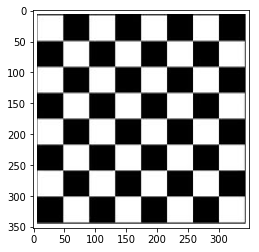

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
I = plt.imread('chessboard.png')
plt.imshow(I,cmap=plt.cm.gray)
plt.show()

Ultimately, what we want to do with this is to create a set of discrete points $(u,v)$ that we can match between images.  These points should correspond to local maxima in the Harris response.  **Given a Harris response matrix, write a function that extracts local maxima, and outputs an array of their coordinates**.  This can be done relatively easily via *non-linear* filtering: loop through all of the pixels in the Harris response, and determine if that pixel is the largest in its neighborhood.  If so, then it's a local maximum.  

In [198]:
# #From Convolution (part 1)
def gaussian_smooth(size, sigma):
    A = np.zeros((size, size))
    x = int(size/2)
    
    for j in range(size):
        for k in range(size):
            new_j = j - x
            new_k = k - x
            numerator = -((new_j*new_j)+(new_k*new_k))
            denominator = (2*sigma*sigma)
            A[j,k] = np.exp(numerator/denominator)
                  
    return A/A.sum()

def convolve(g, h):
    
    A = np.zeros((g.shape))
    k = h.shape[0]
    x = int(k/2)
    
    for i in range(k, g.shape[0]):
        for j in range(k, g.shape[1]):
            adjust_i = i - k
            adjust_j = j - k
            new_image = g[adjust_i:i, adjust_j:j]
            c = new_image * h
            A[i-x, j-x] = c.sum()
    return A

#create Sobel operator 
Sobel_u = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

#create Transpose Sobel operator
Sobel_v = Sobel_u.T


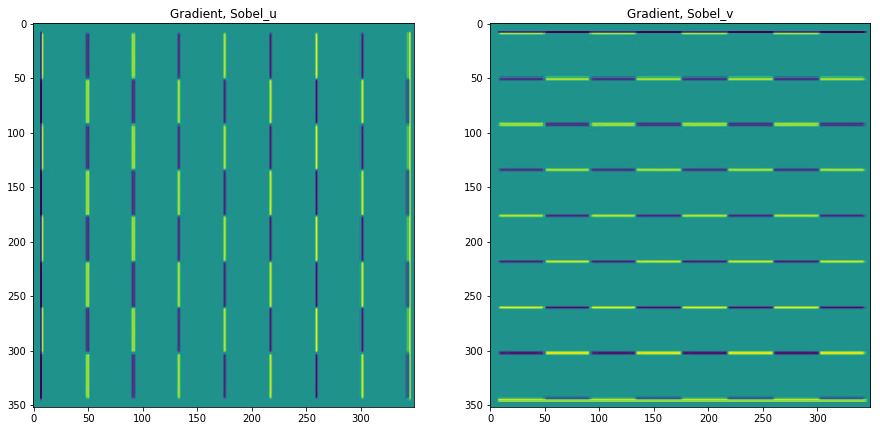

In [199]:
#Edges
I_u = convolve(I, Sobel_u)
I_v = convolve(I, Sobel_v)

fig, x = plt.subplots(ncols=2, figsize=(15, 10))
x[0].imshow(I_u)
x[0].set_title("Gradient, Sobel_u")
x[1].imshow(I_v)
x[1].set_title("Gradient, Sobel_v")
plt.show()

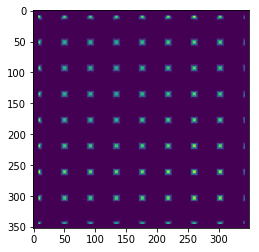

In [200]:
# apply harris response to checkerboard
I_u = convolve(I, Sobel_u)
I_v = convolve(I, Sobel_v)
g = gaussian_smooth(15,2) #always use sigma = 2

I_u2 = convolve(I_u * I_u, g)
I_v2 = convolve(I_v * I_v, g)
I_uv = convolve(I_u * I_v, g)

n = (I_u2 * I_v2) - (I_uv * I_uv)
d = I_u2 + I_v2 + 0.00001

#H = (x * y - z * z) / (x + y)
H = n / d
H[H == np.nan] = 0 # if NaN change to 0

plt.imshow(H)
plt.show()

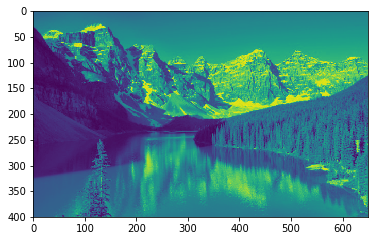

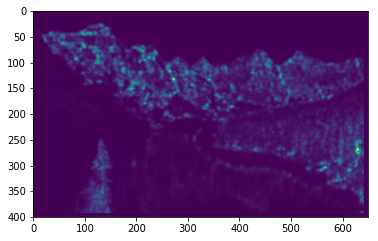

In [201]:
# apply harris to second image for testing
I2 = plt.imread('mountains.jpg')
I2 = I2.mean(axis=2)

I_u = convolve(I2, Sobel_u)
I_v = convolve(I2, Sobel_v)
g = gaussian_smooth(15,2) #always use sigma = 2

I_u2 = convolve(I_u * I_u, g) #x
I_v2 = convolve(I_v * I_v, g) #y
I_uv = convolve(I_u * I_v, g) #z

#H = (x * y - z * z) / (x + y)
n = (I_u2 * I_v2) - (I_uv * I_uv)
d = I_u2 + I_v2 + 0.00001

H2 = n / d
H2[H2 == np.nan] = 0 # if NaN change to 0

plt.imshow(I2)
plt.show()

plt.imshow(H2)
plt.show()

## Non-maximal suppression:
For natural images, you're going to end up with a whole bunch of corners.  We'll want to pare that list down by a substantial amount.  One common approach is to only keep the local maxima that are in the top 5% or 10% as determined by their Harris response strength, or are the top $n$ points as measured by Harris response.  **Write some code that keeps the top $n=100$ local maxima.  Overlay these points on a natural image from which they were computed (don't use the checkerboard).  What is their spatial distribution?**

As you've seen above, an unfortunate side-effect of the Harris detector is that keypoints tend to get clustered in regions of high spatial texture.  Since our ultimate goal is to match these keypoints to those in a second image, then warp that image to the same spatial coordinate system as this one, this non-uniform spatial distribution is somewhat undesirable.  In [this paper](MOPS.pdf), the authors outline a strategy for how to find points that are more spatially uniform, which they call *Adaptive Non-maximal Suppression*.  The procedure is simple: for each potential keypoint, find the distance to the nearest potential keypoint with a larger Harris response.  (Note that in practice, we look for the nearest potential keypoint whose Harris response multiplied by a constant $c$ is greater.  The value of $c$ is usually 0.9).  Then sort the list by this distance (in descending order), and keep the top $n$ points in the list, where $n$ is the number of keypoints that we want to maintain.  **Program this adaptive non-maximal suppression algorithm, and plot the top $n=100$ keypoints on the same image as before.  Does this improve the uniformity of the spatial distribution of points?**  